In [1]:
import torch
from utils import LQR_2D_true_solution, out_put, LQR_1D_true_solution, l_2_compute_1D_Q, l_2_compute_1D_V, true_V_eval_2D
from bases import bases_poly, d_bases_poly, sec_bases_poly, bases_2d, bases_poly_simp, d_bases_poly_simp, sec_bases_poly_simp, bases_2d_simp, bases_poly_2D, bases_poly_2D_s_a, d_bases_poly_2D, bases_poly_2D_simp, d_bases_poly_2D_simp, sec_d_bases_poly_2D, sec_d_bases_poly_2D_simp, bases_poly_2D_s_a_simp
from main_phibe import phibe_finder_1D_LQR, phibe_finder_2D_LQR
from main_RL import RL_finder_1D_LQR, RL_finder_2D_LQR
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

In [2]:
torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

In [3]:
def reward(traj_mat, act_mat):
    # traj_mat shape: (m, I, dim)
    # act_mat shape: (m, I, dim)
    # output shape: (m, I, 1)
    r_1 = torch.einsum("ijk,kl,ijl->ij", traj_mat, Q, traj_mat)
    r_2 = torch.einsum("ijk,kl,ijl->ij", act_mat, R, act_mat)
    return (- r_1 - r_2).unsqueeze(-1)

In [179]:
beta = 0.
A =  0.5 * torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
# A = torch.tensor([[0.6, 0.8], [0.8, -0.6]])
B = torch.tensor([[1, 0.1], [0.1, 1.01]])
sig = 0.
Q = 1 * torch.tensor([[1, 0.2], [0.2, 1.04]])
R = 1 * torch.tensor([[1.2, 0.3], [0.3, 0.8]])

In [180]:
print(torch.linalg.eig(R))
print(torch.linalg.eig(Q))
# smaller difference

torch.return_types.linalg_eig(
eigenvalues=tensor([1.3606+0.j, 0.6394+0.j]),
eigenvectors=tensor([[ 0.8817+0.j, -0.4719+0.j],
        [ 0.4719+0.j,  0.8817+0.j]]))
torch.return_types.linalg_eig(
eigenvalues=tensor([0.8190+0.j, 1.2210+0.j]),
eigenvectors=tensor([[-0.7415+0.j, -0.6710+0.j],
        [ 0.6710+0.j, -0.7415+0.j]]))


In [181]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(3.3742)


In [182]:
print(torch.linalg.eig(A))
print(torch.linalg.eig(B))
# smaller difference

torch.return_types.linalg_eig(
eigenvalues=tensor([-1.2500+0.j, -0.6250+0.j]),
eigenvectors=tensor([[-0.7071+0.j,  0.7071+0.j],
        [-0.7071+0.j, -0.7071+0.j]]))
torch.return_types.linalg_eig(
eigenvalues=tensor([0.9049+0.j, 1.1051+0.j]),
eigenvectors=tensor([[-0.7245+0.j, -0.6892+0.j],
        [ 0.6892+0.j, -0.7245+0.j]]))


In [183]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(6.0570)


In [184]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [185]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.3994,  0.1253],
        [ 0.1163, -0.5850]])
tensor([[0.],
        [0.]])
tensor([ 0.0000, -0.4279,  0.0353, -0.4462])
tensor([ 0.0000, -0.4499,  0.1160, -0.6762])


In [186]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 2
simp_basis = True
deterministic = True
b_val_phibe, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


In [187]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 2
simp_basis = True
deterministic = True
b_val_phibe, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 30/30 [00:18<00:00,  1.60it/s]


In [188]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 2
simple_basis = True
b_val_RL, V_exact_dist_RL = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method: 100%|██████████| 30/30 [00:19<00:00,  1.57it/s]


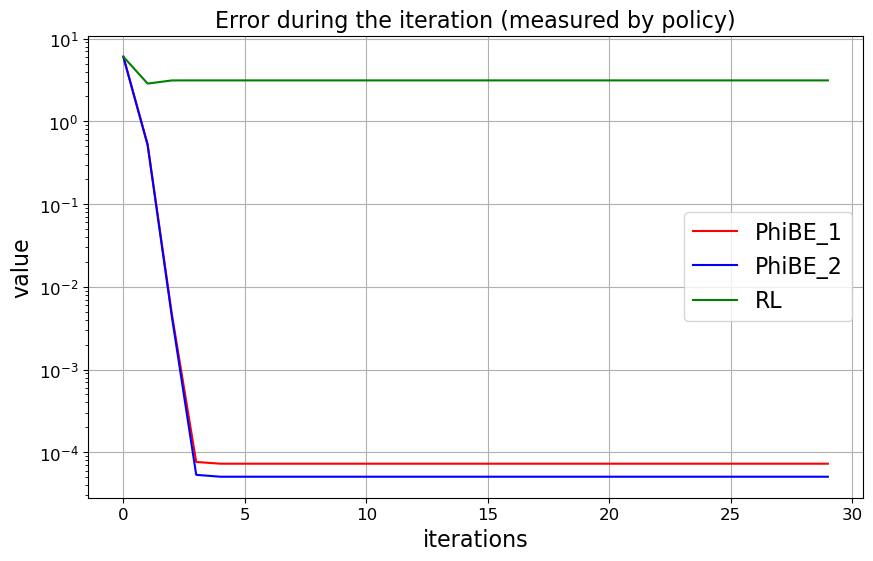

In [189]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:30], dtype=torch.float64)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE_1', color='red')
plt.semilogy(x_values, y_values, label='PhiBE_2', color='blue')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [205]:
beta = 0.
A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
# A = 1 * torch.inverse(torch.tensor([[.4, 0.2], [0.2, 0.4]]))
# A = torch.tensor([[1.5, 0.6], [0.6, 1.8]])
# B = torch.tensor([[0.4, 0.2], [0.2, 0.6]])
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 0.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
# Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))
Q = 1 * torch.tensor([[1, 0.2], [0.2, 1.04]])
R = 1 * torch.tensor([[1.2, 0.3], [0.3, 0.8]])

In [206]:
print(torch.linalg.eig(A))
print(torch.linalg.eig(B))
print(torch.linalg.eig(Q))
print(torch.linalg.eig(R))

torch.return_types.linalg_eig(
eigenvalues=tensor([-2.5000+0.j, -1.2500+0.j]),
eigenvectors=tensor([[-0.7071+0.j,  0.7071+0.j],
        [-0.7071+0.j, -0.7071+0.j]]))
torch.return_types.linalg_eig(
eigenvalues=tensor([0.8000+0.j, 0.4000+0.j]),
eigenvectors=tensor([[ 0.7071+0.j, -0.7071+0.j],
        [ 0.7071+0.j,  0.7071+0.j]]))
torch.return_types.linalg_eig(
eigenvalues=tensor([0.8190+0.j, 1.2210+0.j]),
eigenvectors=tensor([[-0.7415+0.j, -0.6710+0.j],
        [ 0.6710+0.j, -0.7415+0.j]]))
torch.return_types.linalg_eig(
eigenvalues=tensor([1.3606+0.j, 0.6394+0.j]),
eigenvectors=tensor([[ 0.8817+0.j, -0.4719+0.j],
        [ 0.4719+0.j,  0.8817+0.j]]))


In [207]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(25.0000)


In [208]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(6.0570)


In [209]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [210]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.1335,  0.0258],
        [ 0.0115, -0.2110]])
tensor([[0.],
        [0.]])
tensor([ 0.0000, -0.2818,  0.0801, -0.2745])
tensor([ 0.0000, -0.7087,  0.2898, -0.6000])


In [211]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simp_basis = True
deterministic = True
b_val_phibe_1, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:27<00:00,  1.11it/s]


In [216]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simp_basis = True
deterministic = True
b_val_phibe_2, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 30/30 [00:18<00:00,  1.62it/s]


In [217]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simple_basis = True
b_val_RL, V_exact_dist_RL = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method: 100%|██████████| 30/30 [00:19<00:00,  1.53it/s]


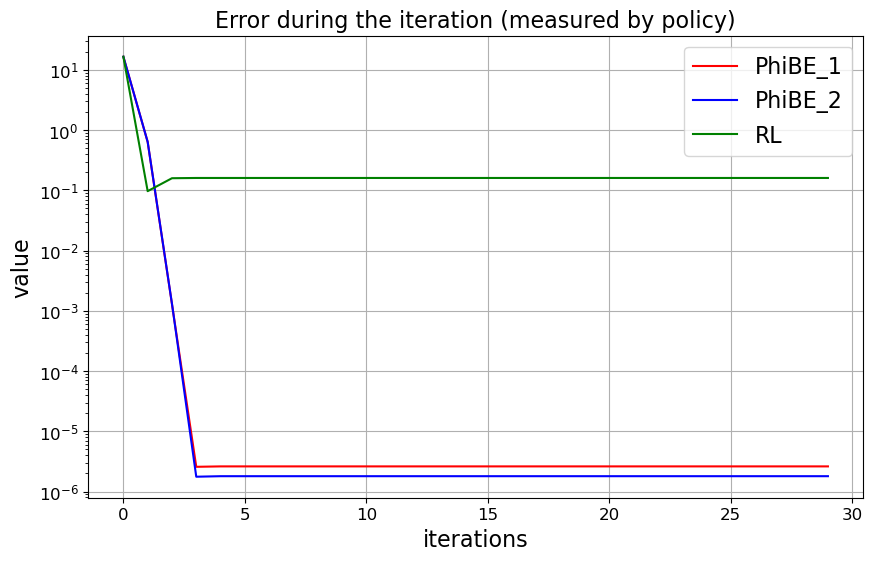

In [218]:
x_tensor = torch.arange(30)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:30], dtype=torch.float64)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE_1', color='red')
plt.semilogy(x_values, y_values, label='PhiBE_2', color='blue')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [371]:
beta = 0.
# A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
A =  0.5 * torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
# A = torch.tensor([[0.6, 0.8], [0.8, -0.6]])
B = torch.tensor([[1, 0.1], [0.1, 1.01]])
# A = 1 * torch.tensor([[-0.9, 0.85], [0.85, -0.88]])
# B = 1 * torch.inverse(torch.tensor([[.4, 0.38], [0.38, 0.4]]))
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 0.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
Q = 1 * torch.inverse(torch.tensor([[.4, 0.35], [0.35, 0.4]]))
R = 1 * torch.tensor([[0.9, 0.85], [0.85, 0.9]])
# Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))

In [372]:
print(torch.linalg.eig(A))
print(torch.linalg.eig(B))
print(torch.linalg.eig(Q))
print(torch.linalg.eig(R))

torch.return_types.linalg_eig(
eigenvalues=tensor([-1.2500+0.j, -0.6250+0.j]),
eigenvectors=tensor([[-0.7071+0.j,  0.7071+0.j],
        [-0.7071+0.j, -0.7071+0.j]]))
torch.return_types.linalg_eig(
eigenvalues=tensor([0.9049+0.j, 1.1051+0.j]),
eigenvectors=tensor([[-0.7245+0.j, -0.6892+0.j],
        [ 0.6892+0.j, -0.7245+0.j]]))
torch.return_types.linalg_eig(
eigenvalues=tensor([20.0000+0.j,  1.3333+0.j]),
eigenvectors=tensor([[ 0.7071+0.j,  0.7071+0.j],
        [-0.7071+0.j,  0.7071+0.j]]))
torch.return_types.linalg_eig(
eigenvalues=tensor([1.7500+0.j, 0.0500+0.j]),
eigenvectors=tensor([[ 0.7071+0.j, -0.7071+0.j],
        [ 0.7071+0.j,  0.7071+0.j]]))


In [373]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(3.3742)


In [374]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(210000.0000)


In [375]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [376]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-9.8068,  9.5130],
        [ 9.5107, -9.8121]])
tensor([[0.],
        [0.]])
tensor([ 0.0000, -0.7670,  0.5962, -0.7718])
tensor([ 0.0000, -0.8485,  0.4161, -0.8818])


In [388]:
bd_low_s = -5
bd_upper_s = 5
bd_low_b = -10
bd_upper_b = 10
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=12
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simp_basis = True
deterministic = True
b_val_phibe_1, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin:  37%|███▋      | 11/30 [00:18<00:31,  1.67s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  60%|██████    | 18/30 [00:30<00:20,  1.67s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  77%|███████▋  | 23/30 [00:38<00:11,  1.67s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  80%|████████  | 24/30 [00:40<00:10,  1.67s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:50<00:00,  1.68s/it]


In [389]:
bd_low_s = -5
bd_upper_s = 5
bd_low_b = -10
bd_upper_b = 10
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=12
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simp_basis = True
deterministic = True
b_val_phibe_2, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin:  33%|███▎      | 10/30 [00:11<00:23,  1.16s/it]

infeasibility detected


Running Optimal Phibe of order 2 using Galerkin:  43%|████▎     | 13/30 [00:15<00:19,  1.15s/it]

infeasibility detected


Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 30/30 [00:38<00:00,  1.30s/it]


In [392]:
bd_low_s = -5
bd_upper_s = 5
bd_low_a = -10
bd_upper_a = 10
reward = reward
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=12
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simple_basis = True
b_val_RL, V_exact_dist_RL = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method:   0%|          | 0/30 [00:00<?, ?it/s]

Running RL method: 100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


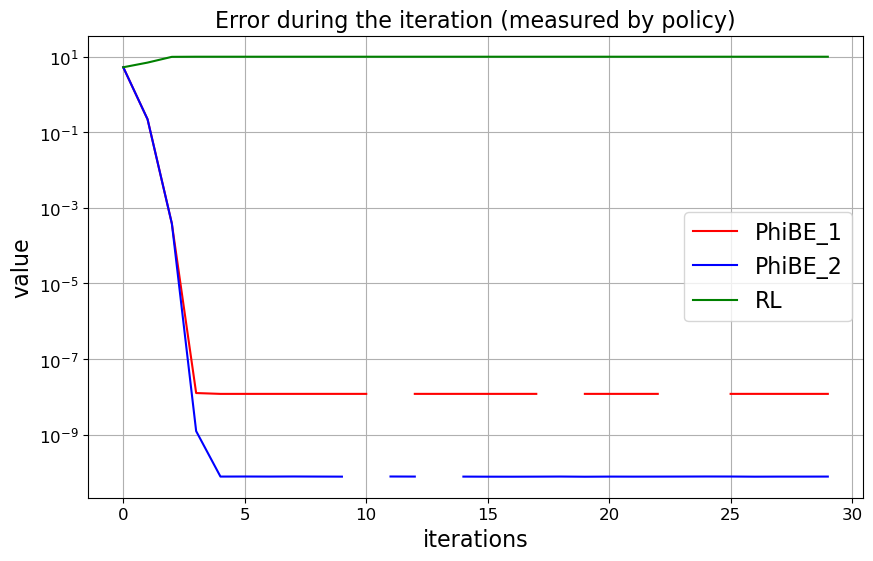

In [393]:
x_tensor = torch.arange(30)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:30], dtype=torch.float64)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE_1', color='red')
plt.semilogy(x_values, y_values, label='PhiBE_2', color='blue')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [394]:
beta = 0.
# A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
B = 1 * torch.tensor([[0.9, 0.85], [0.85, 0.88]])
A = 1 * torch.inverse(torch.tensor([[.4, 0.35], [0.35, 0.4]]))
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 0.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
# Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))
Q = 1 * torch.tensor([[1, 0.2], [0.2, 1.04]])
R = 1 * torch.tensor([[1.2, 0.3], [0.3, 0.8]])

In [395]:
print(torch.linalg.eig(A))
print(torch.linalg.eig(B))
print(torch.linalg.eig(Q))
print(torch.linalg.eig(R))

torch.return_types.linalg_eig(
eigenvalues=tensor([20.0000+0.j,  1.3333+0.j]),
eigenvectors=tensor([[ 0.7071+0.j,  0.7071+0.j],
        [-0.7071+0.j,  0.7071+0.j]]))
torch.return_types.linalg_eig(
eigenvalues=tensor([1.7401+0.j, 0.0399+0.j]),
eigenvectors=tensor([[ 0.7113+0.j, -0.7029+0.j],
        [ 0.7029+0.j,  0.7113+0.j]]))
torch.return_types.linalg_eig(
eigenvalues=tensor([0.8190+0.j, 1.2210+0.j]),
eigenvectors=tensor([[-0.7415+0.j, -0.6710+0.j],
        [ 0.6710+0.j, -0.7415+0.j]]))
torch.return_types.linalg_eig(
eigenvalues=tensor([1.3606+0.j, 0.6394+0.j]),
eigenvectors=tensor([[ 0.8817+0.j, -0.4719+0.j],
        [ 0.4719+0.j,  0.8817+0.j]]))


In [396]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(327222.7078)


In [397]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(6.0570)


In [406]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + 100 * torch.randn(2, 2)
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [407]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-494.1155,  492.5599],
        [ 509.9291, -512.4116]])
tensor([[0.],
        [0.]])
tensor([    0.0000, -8743.7596, 17487.8757, -8747.0079])
tensor([    0.0000, -8891.1967, 17745.2722, -8921.8010])


In [408]:
b_init

tensor([[-556.3512,  452.0072],
        [ 581.7678, -600.4013]])

In [409]:
bd_low_s = -500
bd_upper_s = 500
bd_low_b = -600
bd_upper_b = 600
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simp_basis = True
deterministic = True
b_val_phibe_1, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


In [410]:
bd_low_s = -500
bd_upper_s = 500
bd_low_b = -600
bd_upper_b = 600
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simp_basis = True
deterministic = True
b_val_phibe_2, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin:  70%|███████   | 21/30 [00:12<00:05,  1.66it/s]

infeasibility detected


Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 30/30 [00:18<00:00,  1.62it/s]


In [411]:
print(b_val_phibe_1[-1])
print(b_val_phibe_2[-1])

tensor([[-494.0440,  492.4887],
        [ 510.0084, -512.4912]])
tensor([[-494.1278,  492.5723],
        [ 509.9092, -512.3919]])


In [414]:
bd_low_s = -500
bd_upper_s = 500
bd_low_a = -600
bd_upper_a = 600
reward = reward
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simple_basis = True
b_val_RL_4, V_exact_dist_RL_4 = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s]


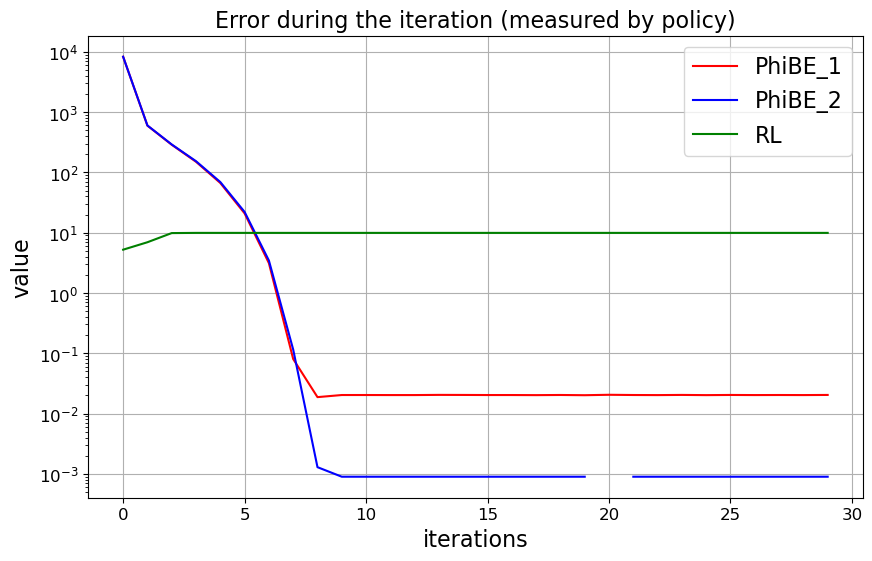

In [415]:
x_tensor = torch.arange(30)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:30], dtype=torch.float64)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE_1', color='red')
plt.semilogy(x_values, y_values, label='PhiBE_2', color='blue')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()